## Homework 8

### Dataset

In this homework, we'll build a model for predicting if we have an image of a dog or a cat. For this, we will use the "Dogs & Cats" dataset that can be downloaded from [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data).

You need to download the `train.zip` file.

If you have troubles downloading from Kaggle, use [this link](https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats/train.zip) instead:
```bash
wget https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats/train.zip
```
In the lectures we saw how to use a pre-trained neural network. In the homework, we'll train a much smaller model from scratch.

**Note:** You don't need a computer with a GPU for this homework. A laptop or any personal computer should be sufficient.

In [ ]:
!wget --directory-prefix=data/ https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats/train.zip

### Data Preparation

The dataset contains 12,500 images of cats and 12,500 images of dogs.

Now we need to split this data into train and validation

* Create a `train` and `validation` folders
* In each folder, create `cats` and `dogs` folders
* Move the first 10,000 images to the train folder (from 0 to 9999) for boths cats and dogs - and put them in respective folders
* Move the remaining 2,500 images to the validation folder (from 10000 to 12499)

You can do this manually or with Python (check `os` and `shutil` packages).

In [2]:
import shutil
import os

In [3]:
data_path = 'data'
source_names = ['train', 'validation']
class_names = ['cats', 'dogs']

for dir_name in source_names:
    for class_name in class_names:
        os.makedirs(os.path.join(data_path, dir_name, class_name), exist_ok=True)

In [ ]:
shutil.unpack_archive('data/train.zip', data_path)

train_path = os.path.join(data_path, 'train')
val_path = os.path.join(data_path, 'validation')
for class_name in class_names:
    for i in range(12500):
        filename = class_name[:-1] + '.' + str(i) + '.jpg'
        src_path = os.path.join(train_path, filename)
        if i < 10000:
            dest_path = os.path.join(train_path, class_name)
        else:
            dest_path = os.path.join(val_path, class_name)
        shutil.move(src_path, dest_path)

### Model

For this homework we will use Convolutional Neural Network (CNN. Like in the lectures, we'll use Keras.

You need to develop the model with following structure:

* The shape for input should be `(150, 150, 3)`
* Next, create a covolutional layer ([`Conv2D`](https://keras.io/api/layers/convolution_layers/convolution2d/)):
    * Use 32 filters
    * Kernel size should be `(3, 3)` (that's the size of the filter)
    * Use `'relu'` as activation 
* Reduce the size of the feature map with max pooling ([`MaxPooling2D`](https://keras.io/api/layers/pooling_layers/max_pooling2d/))
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using a [`Flatten`](https://keras.io/api/layers/reshaping_layers/flatten/) layer
* Next, add a `Dense` layer with 64 neurons and `'relu'` activation
* Finally, create the `Dense` layer with 1 neuron - this will be the output
    * The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use [`SGD`](https://keras.io/api/optimizers/sgd/) with the following parameters:

* `SGD(lr=0.002, momentum=0.8)`

For clarification about kernel size and max pooling, check [Week #11 Office Hours](https://www.youtube.com/watch?v=1WRgdBTUaAc).

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
def make_model(learning_rate=0.1, size_inner=100):
    inputs = keras.Input(shape=(150, 150, 3))
    conv_out = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
    pool_out = layers.MaxPooling2D(pool_size=(2, 2))(conv_out)
    vectors = layers.Flatten()(pool_out)
    inner = layers.Dense(size_inner, activation='relu')(vectors)
    outputs = layers.Dense(1, activation='sigmoid')(inner)
    model = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    loss = keras.losses.BinaryCrossentropy()

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [7]:
learning_rate = 0.002
size = 64
model = make_model(learning_rate=learning_rate, size_inner=size)

### Question 1

Since we have a binary classification problem, what is the best loss function for us?

Note: since we specify an activation for the output layer, we don't need to set `from_logits=True`

**Answer:** should be BinaryCrossentropy.

### Question 2

What's the total number of parameters of the model? You can use the `summary` method for that.

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                11214912  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 11,215,873
Trainable params: 11,215,873
Non-trainable params: 0
__________________________________________

### Generators and Training

For the next two questions, use the following data generator for both train and validation:

```python
ImageDataGenerator(rescale=1./255)
```

* We don't need to do any additional pre-processing for the images.
* When reading the data from train/val directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
* Use `batch_size=20`
* Use `shuffle=True` for both training and validaition 

For training use `.fit()` with the following params:

```python
model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)
```

Note `validation_steps=50` - this parameter says "run only 50 steps on the validation data for evaluating the results". 
This way we iterate a bit faster, but don't use the entire validation dataset.
That's why it's important to shuffle the validation dataset as well. 

In [9]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = datagen.flow_from_directory(
    'data/validation',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [11]:
train_generator.class_mode, validation_generator.class_mode

('binary', 'binary')

In [12]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 56s 557ms/step - loss: 0.6986 - accuracy: 0.5060 - val_loss: 0.6886 - val_accuracy: 0.5510
Epoch 2/10
100/100 [==============================] - 55s 553ms/step - loss: 0.6886 - accuracy: 0.5430 - val_loss: 0.6860 - val_accuracy: 0.5610
Epoch 3/10
100/100 [==============================] - 55s 555ms/step - loss: 0.6839 - accuracy: 0.5560 - val_loss: 0.6796 - val_accuracy: 0.5380
Epoch 4/10
100/100 [==============================] - 55s 552ms/step - loss: 0.6807 - accuracy: 0.5785 - val_loss: 0.6826 - val_accuracy: 0.5650
Epoch 5/10
100/100 [==============================] - 54s 543ms/step - loss: 0.6821 - accuracy: 0.5725 - val_loss: 0.6647 - val_accuracy: 0.6250
Epoch 6/10
100/100 [==============================] - 53s 533ms/step - loss: 0.6787 - accuracy: 0.5795 - val_loss: 0.6726 - val_accuracy: 0.5790
Epoch 7/10
100/100 [==============================] - 53s 526ms/step - loss: 0.6804 - accuracy: 0.5635 - val_loss: 0.6882 - val_ac

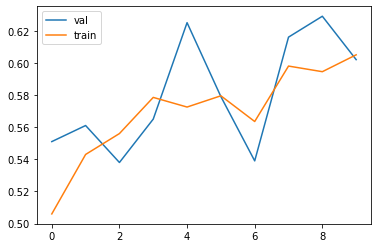

In [14]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')
plt.legend();

### Question 3

What is the median of training accuracy for this model?

In [15]:
np.median(history.history['accuracy'])

0.5754999816417694

### Question 4

What is the standard deviation of training loss for this model?

In [16]:
np.std(history.history['loss'])

0.008639343809373676

### Data Augmentation

For the next two questions, we'll generate more data using data augmentations. 

Add the following augmentations to your training data generator:

* `rotation_range=40,`
* `width_shift_range=0.2,`
* `height_shift_range=0.2,`
* `shear_range=0.2,`
* `zoom_range=0.2,`
* `horizontal_flip=True,`
* `fill_mode='nearest'`

In [17]:
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_generator_aug = train_datagen_aug.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


### Question 5

Let's train our model for 10 more epochs using the same code as previously. Make sure you don't re-create the model - we want to continue training the model we already started training.

What is the mean of validation loss for the model trained with augmentations?

In [18]:
history_aug = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 57s 568ms/step - loss: 0.6582 - accuracy: 0.6020 - val_loss: 0.6512 - val_accuracy: 0.6270
Epoch 2/10
100/100 [==============================] - 52s 519ms/step - loss: 0.6483 - accuracy: 0.6165 - val_loss: 0.6734 - val_accuracy: 0.5970
Epoch 3/10
100/100 [==============================] - 51s 507ms/step - loss: 0.6629 - accuracy: 0.5910 - val_loss: 0.6914 - val_accuracy: 0.5450
Epoch 4/10
100/100 [==============================] - 53s 527ms/step - loss: 0.6532 - accuracy: 0.6070 - val_loss: 0.6606 - val_accuracy: 0.6070
Epoch 5/10
100/100 [==============================] - 49s 486ms/step - loss: 0.6411 - accuracy: 0.6345 - val_loss: 0.6503 - val_accuracy: 0.6070
Epoch 6/10
100/100 [==============================] - 48s 484ms/step - loss: 0.6434 - accuracy: 0.6220 - val_loss: 0.6502 - val_accuracy: 0.6240
Epoch 7/10
100/100 [==============================] - 47s 466ms/step - loss: 0.6359 - accuracy: 0.6335 - val_loss: 0.6399 - val_ac

In [19]:
history_aug.history['val_loss']

[0.6511610150337219,
 0.6734278798103333,
 0.6913506388664246,
 0.6605825424194336,
 0.6503498554229736,
 0.6501848697662354,
 0.639933705329895,
 0.6725988984107971,
 0.6573658585548401,
 0.6620637774467468]

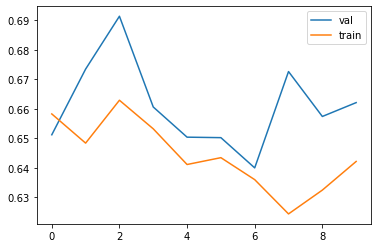

In [20]:
hist = history_aug.history
plt.plot(hist['val_loss'], label='val')
plt.plot(hist['loss'], label='train')
plt.legend();

In [21]:
np.mean(history_aug.history['val_loss'])

0.6609019041061401

### Question 6

What's the average of validation accuracy for the last 5 epochs (from 6 to 10) for the model trained with augmentations?

In [22]:
history_aug.history['val_accuracy']

[0.6269999742507935,
 0.597000002861023,
 0.5450000166893005,
 0.6069999933242798,
 0.6069999933242798,
 0.6240000128746033,
 0.6259999871253967,
 0.6140000224113464,
 0.6190000176429749,
 0.6100000143051147]

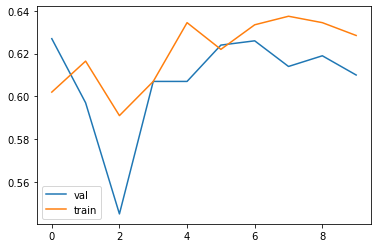

In [23]:
hist = history_aug.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')
plt.legend();

In [24]:
np.average(history_aug.history['val_accuracy'][-5:])

0.6186000108718872